# Investigating applications of graph algorithms on real TFL data

#### import statements

In [365]:
import math
from collections import deque
import pandas as pd
import heapq
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import random

### Queue Data Structure (FIFO)
Queue has the following properties:
- enqueue(): adds object to the rear of the queue
- dequeue(): removes the front most element and shifts prior elements towards right
- size: returns the total number of objects in the queue
- isEmpty(): returns True when no objects are stored in the queue
- get_length(): returns the total number of objects in the queue

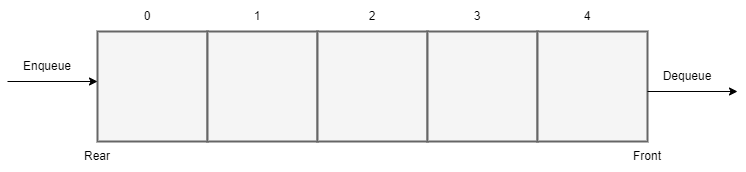

In [366]:
class Queue:
    def __init__(self):
        self.queue = deque()
    def enqueue(self, item):
        self.queue.append(item)
    def dequeue(self):
        if len(self.queue) < 1:
            return None
        return self.queue.popleft()
    def size(self):
        return len(self.queue)
    def isEmpty(self):
        return len(self.queue) == 0
    def get_length(self):
        return len(self.queue)

### Stack Data Structure (LIFO)
Stack has the following properties:
- push(): adds object to the top of the stack
- pop(): removes object from the top of the stack and returns it
- isEmpty(): returns True when no objects are stored in the stack
- peek(): returns the first object located at the top of the stack without removing it from the stack

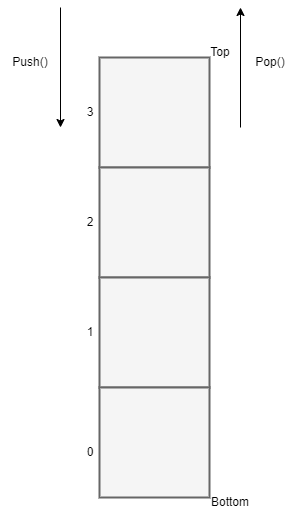

In [367]:
class Stack:
    def __init__(self):
        self.stack = []
    def push(self,item):
        self.stack.append(item)
    def pop(self):
        self.stack.pop()
    def isEmpty(self):
        return not self.stack
    def peek(self):
        return self.stack[-1]

### Graph Data Structure
Graph is represented using an adjacency list and has the following properties:
- add_vertex(node): adds new vertex to the graph
- get_vertex(n): returns the vertex object when given the name of a vertex. If name of vertex does not exist in graph then return None
- get_vertices(): returns the names of all vertex objects in the graph
- add_edge(frm, to, cost): adds new edge to the graph between two nodes including the cost(weight) between two nodes. (optional parameter "line" is used for our tfl application)

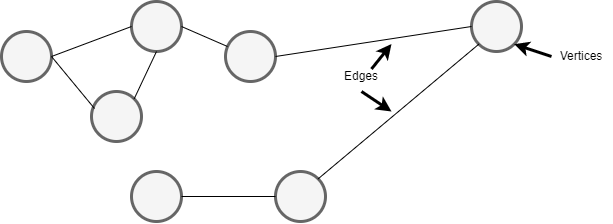

In [368]:
class Vertex:
    def __init__(self, name):
        self.name = name
        self.adjacent = []

    def add_neighbor(self, neighbor, weight=0,line=''):
        self.adjacent.append((neighbor,weight,line))
        
    def get_connections(self):
        return self.adjacent
    
    def get_name(self):
        return self.name
    
    def get_weight(self, neighbor):
        for x in self.adjacent:
            if x[0].name == neighbor:
                return x[1]
        return None

In [369]:
class Graph:
    def __init__(self):
        self.graph = {}

    def __iter__(self): 
        return iter(self.graph.values())

    def add_vertex(self, vertex):
        new_vertex = Vertex(vertex)
        self.graph[vertex] = new_vertex

    def get_vertex(self, n):
        if n in self.graph:
            return self.graph[n]
        else:
            return None
    def get_vertices(self):
        return self.graph.keys()
    
    def add_edge(self,frm, to, cost = 0,line=''):
        if frm not in self.graph:
            self.add_vertex(frm)
        if to not in self.graph:
            self.add_vertex(to)
        self.graph[frm].add_neighbor(self.graph[to], cost,line)
        self.graph[to].add_neighbor(self.graph[frm], cost, line)

### Euclidean distance
We must be able to find the distance between two stations using longitude and latitude coordinates,
I have used: https://www.nhc.noaa.gov/gccalc.shtml to verify our calculations are correct

In [370]:
def euclidean_distance(lon1, lat1, lon2, lat2):
    radius = 6371
    lat1 = lat1 * math.pi / 180
    lat2 = lat2 * math.pi / 180
    lon1 = lon1 * math.pi / 180
    lon2 = lon2 * math.pi / 180
    dlat = lat2 - lat1
    dlon = lon2 - lon1 
    x = dlon * math.cos((lat1 + lat2) / 2)
    y = dlat
    distance = radius * math.sqrt(x**2 + y**2)
    distance = distance * (5/8)
    return distance

### Iterative Depth first Search

In [371]:
def dfs_iterative(graph, start_vertex):
    path = []
    stack = [start_vertex]
    while(len(stack) != 0):
        s = stack.pop()
        if s not in path:
            path.append(s)
        if s not in graph:
            continue
        for neighbor in graph[s]:
            stack.append(neighbor)
    return path

In [372]:
railway = Graph()

### Load data into railway graph

In [373]:
df = pd.read_csv('stations.csv')        
stations = df['Station name'].to_list()
latitudes  = df['Latitude'].to_list()
longitudes = df['Longitude'].to_list()

df = pd.read_csv('connections.csv')
fromStations = df['From Station'].to_list()
toStations = df['To Station'].to_list()

for i in range(0,len(fromStations)):
    fromIndex = stations.index(fromStations[i])
    toIndex = stations.index(toStations[i])
    flong = longitudes[fromIndex]
    flat = latitudes[toIndex]
    tlong = longitudes[toIndex]
    tlat = latitudes[fromIndex]
    weight = euclidean_distance(flong,flat,tlong,tlat)
    railway.add_edge(fromStations[i],toStations[i],weight)

### Minimum Stops
To find the minimum number of stops to travel between two selected stations, we can use the Breadth First Search algorithm

In [374]:
def minStops(fromS, toS):
    queue = Queue()
    queue.enqueue([fromS])
    visited = set()
    while queue.size() != 0:
        path = queue.dequeue()
        vertex = path[-1]
        if vertex == toS:
            return path
        elif vertex not in visited:
            for x in railway.get_vertex(vertex).get_connections():
                new_path = list(path)
                new_path.append(x[0].name)
                queue.enqueue(new_path)
            visited.add(vertex)
    return minStops

###### Test

In [375]:
begin_index, end_index = random.sample(range(len(stations)), 2)
print(f"Minimum stops between {stations[begin_index]} and {stations[end_index]}: ")
print(minStops(stations[begin_index], stations[end_index]))

Minimum stops between Ockendon and South Merton: 
['Ockendon', 'Upminster', 'Barking', 'Stratford', 'Liverpool Street', 'Bank', 'Waterloo', 'Vauxhall', 'Queenstown Road', 'Clapham Junction', 'Earlsfield', 'Wimbledon', 'Wimbledon Chase', 'South Merton']


### Minimum Distance
To find the minimum distance to travel between two stations, we can use Dijkstras algorithm 

In [376]:
def minDistance(fromS, toS):
    minDistance = 0
    distances = {}
    for vertex in railway:
        distances[vertex.name] = float('inf')

    distances[fromS] = 0
    priority_queue = [(0, fromS)]
    while len(priority_queue) > 0:
        current = heapq.heappop(priority_queue)
        current_distance = current[0]
        current_vertex = current[1] 
        if current_distance > distances[current_vertex]:
            continue
        else:            
            for neighbour in railway.get_vertex(current_vertex).get_connections():
                old_distance = current_distance + neighbour[1]
                if old_distance < distances[neighbour[0].name]:
                    distances[neighbour[0].name] = old_distance
                    heapq.heappush(priority_queue, (old_distance, neighbour[0].name))
        minDistance = distances[toS]
    return minDistance

###### Test

In [379]:
begin_index, end_index = random.sample(range(len(stations)), 2)
print(f"Minimum Distance between {stations[begin_index]} and {stations[end_index]}: ")
print(minDistance(stations[begin_index], stations[end_index]),"km")

Minimum Distance between Wapping and Mortlake: 
11.253922690588311 km


### Minimum Distance
To find the minimum distance to travel between two stations, we can use Dijkstras algorithm

In [380]:
def travellingSalesMan(inputList):
    network = Graph()
    seen = []
    for from_ in inputList:
        network.add_vertex(from_)
        for to in inputList:
            if from_ not in seen:
                if to != from_:
                    toLat = latitudes[stations.index(to)]
                    toLon = longitudes[stations.index(to)]
                    fromLat = latitudes[stations.index(from_)]
                    fromLon = longitudes[stations.index(from_)]
                    weight = euclidean_distance(toLon,toLat,fromLon,fromLat)
                    network.add_edge(from_,to,weight)
                seen.append(to)
    starting_vertex = inputList[0]
    max_ = 0
    for station in inputList:
        sum_ = 0
        for x in network.get_vertex(station).get_connections():
            sum_ += x[1]
        if sum_ > max_:
            max_ = sum_
            starting_vertex = station

    mst = defaultdict(set)
    visited = set([starting_vertex])
    edges = []
    for neighbour in network.get_vertex(starting_vertex).get_connections():
        edges.append((neighbour[1], starting_vertex, neighbour[0].name))
    heapq.heapify(edges)

    while len(edges) > 0:
        current_edge = heapq.heappop(edges)
        from_ = current_edge[1]
        to = current_edge[2]
        if to not in visited:
            visited.add(to)
            mst[from_].add(to)
            for neighbour in network.get_vertex(to).get_connections():
                if neighbour[0].name not in visited:
                    heapq.heappush(edges, (neighbour[1], to, neighbour[0].name))
    keys = list(mst.keys())
    visited = dfs_iterative(mst,keys[0])
    return visited

###### Test

In [381]:
indexes = random.sample(range(len(stations)), 5)
print(f"Given these stations: {[stations[index] for index in indexes]}: ")
print(f"The visited stations are:", travellingSalesMan([stations[index]for index in indexes]))

Given these stations: ['Wapping', 'East Ham', 'Wandsworth Common', 'Falconwood', 'Northwood Hills']: 
The visited stations are: ['Northwood Hills', 'Wandsworth Common', 'Wapping', 'East Ham', 'Falconwood']
